In [1]:
import numpy as np
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import glob
from glob import glob
import cartopy
import cartopy.crs as ccrs
import seawater as sw
from seawater.library import T90conv
import warnings
warnings.filterwarnings('ignore')
import cmath
import esmlab
import ncar_jobqueue
from dask.distributed import Client
import cmocean

### GLODAP data
#### These data have been vertically interpolated onto the POP grid z_t levels
#### This was done using this notebook:
#### /glade/u/home/kristenk/besome/alk_calc_paper/GLODAP_to_POP_z_t.ipynb

In [2]:
file = '/glade/work/kristenk/GLODAPv2_regridded/glodap_pop_vert_levels/GLODAPv2_POP_z_t.nc'
ds = xr.open_dataset(file,decode_times=False,decode_coords=False)

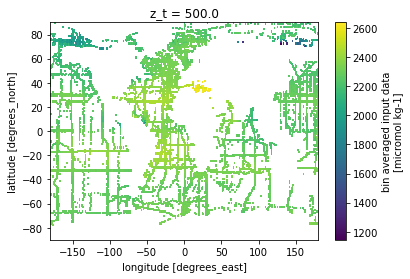

In [3]:
ds.TAlkInput_mean.isel(z_t=0).plot()

### First, define PAlk and nNO3

In [4]:
no3_sf=1 #1.36 in Fry et al. (2015), 1 in Sarmiento et al. (2002)

# PAlk=(ds.TAlkInput_mean + no3_sf * ds.NO3Input_mean)/ ds.salinityInput_mean * 35.

# nNO3=ds.NO3Input_mean * 35./ds.salinityInput_mean

no3_sf=1 #1.36 in Fry et al. (2015), 1 in Sarmiento et al. (2002)

PAlk=(ds.TAlk+ no3_sf * ds.NO3)/ ds.salinity * 35.

nNO3=ds.NO3 * 35./ds.salinity

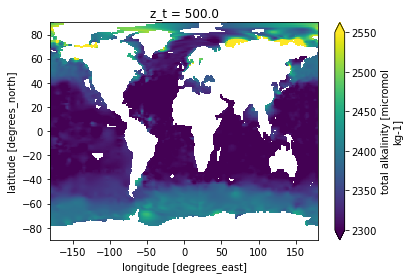

In [5]:
PAlk.isel(z_t=0).plot(vmin=2300,vmax=2550)

In [6]:
#add them to the dataset
ds['PAlk'] = xr.DataArray(PAlk,dims=('z_t','lat','lon'))
ds['nNO3'] = xr. DataArray(nNO3,dims=('z_t','lat','lon'))

### Make "surface' and 'deep' averages

#### These data are verically interpolated onto the CESM z_t levels
#### I take the average over top 10 levels (0-100m) for the surface box
#### and levels 11 to 20 (100-200m) for the deep box

#### Sarmiento et al. (2002): surface box is 0-100m and deep box is 100-200m

In [7]:
nNO3_surface = ds.nNO3.isel(z_t=slice(0,10)).mean(dim='z_t')
nNO3_deep = ds.nNO3.isel(z_t=slice(10,20)).mean(dim='z_t') 

PAlk_surface = ds.PAlk.isel(z_t=slice(0,10)).mean(dim='z_t')
PAlk_deep = ds.PAlk.isel(z_t=slice(10,20)).mean(dim='z_t')

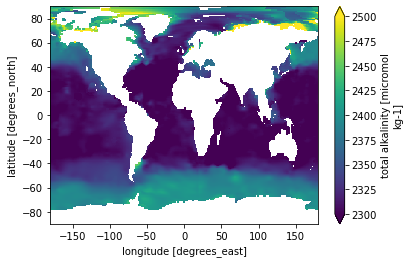

In [8]:
PAlk_surface.plot(vmin=2300,vmax=2500)

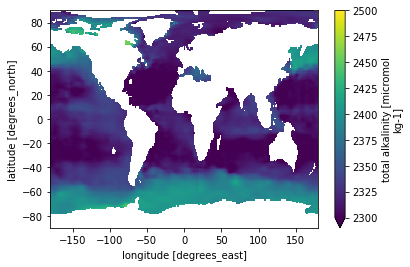

In [9]:
PAlk_deep.plot(vmin=2300,vmax=2500)

In [10]:
area = xr.DataArray(np.zeros([180,360]), dims=('lat','lon'))

In [11]:
j=0

for lat in ds.lat.values:
    
    pi     =    3.14159265359
    radius = 6378.137

    deg2rad = pi / 180.0

    resolution_lat =1.
    resolution_lon =1.

    elevation = deg2rad * (lat + (resolution_lat / 2.0))

    deltalat = deg2rad * resolution_lon
    deltalon = deg2rad * resolution_lat

    area[j,:] = (2.0*radius**2*deltalon*np.cos(elevation)*np.sin((deltalat/2.0)))
    
    j = j + 1


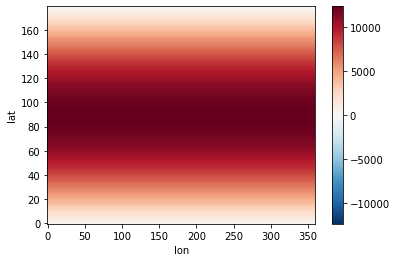

In [12]:
area.plot()

In [13]:
ds['area']=area

In [14]:
rain_ratio=(1/14.6) * ((PAlk_deep - PAlk_surface)/(nNO3_deep - nNO3_surface))

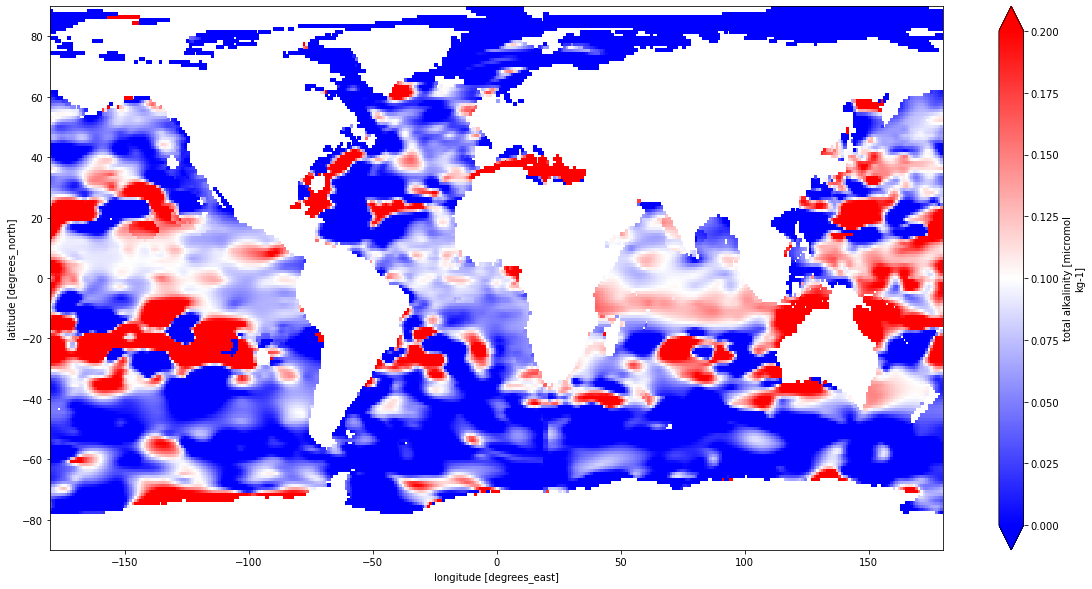

In [15]:
rain_ratio.plot(vmin=0,vmax=0.2,figsize=(20,10),cmap='bwr',)

### Sarmiento et al 2002 global average export ratio = 0.056

In [16]:
#global_mean_rr = rain_ratio.mean()
global_mean_rr = esmlab.weighted_mean(rain_ratio, weights=ds.area, dim=['lat', 'lon']).compute()
global_mean_rr

<xarray.DataArray ()>
array(0.06871601)
Attributes:
    long_name:  total alkalinity
    units:      micromol kg-1

In [17]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8
    
    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

### Now do CESM rain ratio

In [18]:
case = 'cesm22cocco.G1850ECOIAF.T62_g17.003'
path = '/glade/scratch/kristenk/archive/' + case + '/ocn/proc/mean5thIAF'

In [19]:
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/mean5thIAF/mean_IAF5_POC_FLUX_IN.nc'
cesm_ds = xr.open_dataset(file,decode_times=False,decode_coords=False)

In [20]:
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/mean5thIAF/mean_IAF5_CaCO3_FLUX_IN.nc'
ds_tmp = xr.open_dataset(file,decode_times=False,decode_coords=False)
cesm_ds['CaCO3_FLUX_IN']=ds_tmp['CaCO3_FLUX_IN']

In [21]:
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/mean5thIAF/mean_IAF5_NO3.nc'
ds_tmp = xr.open_dataset(file,decode_times=False,decode_coords=False)
cesm_ds['NO3']=ds_tmp['NO3']

In [22]:
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/mean5thIAF/mean_IAF5_SALT.nc'
ds_tmp = xr.open_dataset(file,decode_times=False,decode_coords=False)
cesm_ds['SALT']=ds_tmp['SALT']

In [23]:
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/mean5thIAF/mean_IAF5_ALK.nc'
ds_tmp = xr.open_dataset(file,decode_times=False,decode_coords=False)
cesm_ds['ALK']=ds_tmp['ALK']

In [24]:
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/mean5thIAF/mean_IAF5_ALK_ALT_CO2.nc'
ds_tmp = xr.open_dataset(file,decode_times=False,decode_coords=False)
cesm_ds['ALK_noGCB']=ds_tmp['ALK_ALT_CO2']

In [25]:
case = 'cesm22cocco.G1850ECOIAF.T62_g17.004'
path = '/glade/scratch/kristenk/archive/' + case + '/ocn/proc/mean5thIAF'

In [26]:
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/mean5thIAF/mean_IAF5_ALK_ALT_CO2.nc'
ds_tmp = xr.open_dataset(file,decode_times=False,decode_coords=False)
cesm_ds['ALK_2xGCB']=ds_tmp['ALK_ALT_CO2']

In [27]:
no3_sf=1 #1.36 in Fry et al., 2015 (accounts for other ions used in primary production)
nNO3=cesm_ds.NO3 * 35./cesm_ds.SALT

PAlk=(cesm_ds.ALK + no3_sf * cesm_ds.NO3)/ cesm_ds.SALT * 35.
PAlk_2xGCB = (cesm_ds.ALK_2xGCB + no3_sf * cesm_ds.NO3)/ cesm_ds.SALT * 35.
PAlk_noGCB = (cesm_ds.ALK_noGCB + no3_sf * cesm_ds.NO3)/ cesm_ds.SALT * 35.

In [28]:
#add them to the dataset
cesm_ds['PAlk'] = xr.DataArray(PAlk,dims=('z_t','nlat','nlon'))
cesm_ds['PAlk_2xGCB'] = xr.DataArray(PAlk_2xGCB,dims=('z_t','nlat','nlon'))
cesm_ds['PAlk_noGCB'] = xr.DataArray(PAlk_noGCB,dims=('z_t','nlat','nlon'))
cesm_ds['nNO3'] = xr. DataArray(nNO3,dims=('z_t','nlat','nlon'))

In [29]:
depths_m = cesm_ds.z_t / 100.

#### for CESM, I take the average over top 10 levels (0-100m) for the surface box
#### and levels 11 to 20 (100-200m) for the deep box

#### Sarmiento et al. (2002): surface box is 0-100m and deep box is 100-200m

In [30]:
nNO3_surface = cesm_ds.nNO3.isel(z_t=slice(0,10)).mean(dim='z_t')
nNO3_deep = cesm_ds.nNO3.isel(z_t=slice(10,20)).mean(dim='z_t') 


## CONTROL #######################################################
PAlk_surface = cesm_ds.PAlk.isel(z_t=slice(0,10)).mean(dim='z_t')
PAlk_deep = cesm_ds.PAlk.isel(z_t=slice(10,20)).mean(dim='z_t')

cesm_rain_ratio=(1/14.6) * ((PAlk_deep - PAlk_surface)/(nNO3_deep - nNO3_surface))

In [31]:
## noGCB #######################################################
PAlk_surface = cesm_ds.PAlk_noGCB.isel(z_t=slice(0,10)).mean(dim='z_t')
PAlk_deep = cesm_ds.PAlk_noGCB.isel(z_t=slice(10,20)).mean(dim='z_t')

cesm_rain_ratio_noGCB=(1/14.6) * ((PAlk_deep - PAlk_surface)/(nNO3_deep - nNO3_surface))

In [32]:
## 2xGCB #######################################################
PAlk_surface = cesm_ds.PAlk_2xGCB.isel(z_t=slice(0,10)).mean(dim='z_t')
PAlk_deep = cesm_ds.PAlk_2xGCB.isel(z_t=slice(10,20)).mean(dim='z_t')

cesm_rain_ratio_2xGCB=(1/14.6) * ((PAlk_deep - PAlk_surface)/(nNO3_deep - nNO3_surface))

In [33]:
#get this file for the lons and lats
file = '/glade/work/kristenk/WOA_data/regrid_POP/WOA2013_POPgrid.nc'
ds_woa = xr.load_dataset(file, decode_times=False, decode_coords=False)
lons=ds_woa.TLONG
lats=ds_woa.TLAT
area=ds_woa.TAREA

In [34]:
global_mean_rr_cesm_control = esmlab.weighted_mean(cesm_rain_ratio, weights=cesm_ds.TAREA, dim=['nlat', 'nlon']).compute()
global_mean_rr_cesm_control.values

array(0.06902356)

In [35]:
global_mean_rr_cesm_noGCB = esmlab.weighted_mean(cesm_rain_ratio_noGCB, weights=cesm_ds.TAREA, dim=['nlat', 'nlon']).compute()
global_mean_rr_cesm_noGCB.values

array(0.04914602)

In [36]:
global_mean_rr_cesm_2xGCB = esmlab.weighted_mean(cesm_rain_ratio_2xGCB, weights=cesm_ds.TAREA, dim=['nlat', 'nlon']).compute()
global_mean_rr_cesm_2xGCB.values

array(0.0889014)

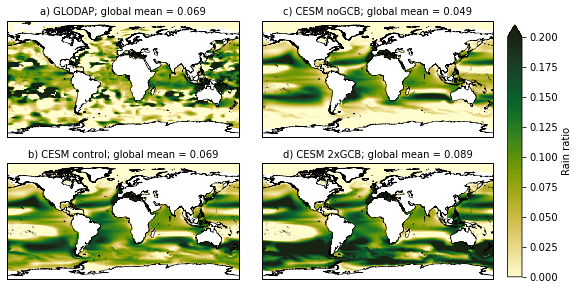

In [37]:
fig = plt.figure(figsize=(10,5))
#plt.suptitle('Rain ratio, Sarmiento et al., 2002 method: GLODAP and CESM', fontsize=14)

#---- GLODAP panel
ax = fig.add_subplot(2,2,1, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('a) GLODAP; global mean = 0.069', fontsize=10,x=0.5, y=1)
pc1=ax.pcolormesh(rain_ratio.lon, rain_ratio.lat,rain_ratio, vmin=0, vmax=0.2, cmap=cmocean.cm.speed,
                 transform=ccrs.PlateCarree())


#---- CESM panel control
lon,lat,field=adjust_pop_grid(lons, lats, cesm_rain_ratio)
ax = fig.add_subplot(2,2,3, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('b) CESM control; global mean = 0.069', fontsize=10,x=0.5, y=1)
pc2=ax.pcolormesh(lon, lat, field, vmin=0, vmax=0.2, cmap=cmocean.cm.speed,
                 transform=ccrs.PlateCarree())


#---- CESM panel noGCB
lon,lat,field=adjust_pop_grid(lons, lats, cesm_rain_ratio_noGCB)
ax = fig.add_subplot(2,2,2, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('c) CESM noGCB; global mean = 0.049', fontsize=10,x=0.5, y=1)
pc2=ax.pcolormesh(lon, lat, field, vmin=0, vmax=0.2, cmap=cmocean.cm.speed,
                 transform=ccrs.PlateCarree())



#---- CESM panel 2xGCB
lon,lat,field=adjust_pop_grid(lons, lats, cesm_rain_ratio_2xGCB)
ax = fig.add_subplot(2,2,4, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('d) CESM 2xGCB; global mean = 0.089', fontsize=10,x=0.5, y=1)
pc2=ax.pcolormesh(lon, lat, field,vmin=0, vmax=0.2, cmap=cmocean.cm.speed,
                 transform=ccrs.PlateCarree())



fig.subplots_adjust(right=0.8,hspace=0.1,wspace=0.1)
cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc2, cax=cbar_ax,label='Rain ratio',extend='max')

fig.savefig('/glade/u/home/kristenk/besome/alk_calc_paper/Figs/rainratio.png',dpi=600, bbox_inches='tight',format='png');


In [83]:
### calculate experiment differences from control
noGCBdiff=cesm_rain_ratio_noGCB - cesm_rain_ratio
GCB2xdiff=cesm_rain_ratio_2xGCB - cesm_rain_ratio

In [86]:
lat_grd=np.empty([180,360])
for y in np.arange(0,180):
    lat_grd[y,:]=ds.lat[y]

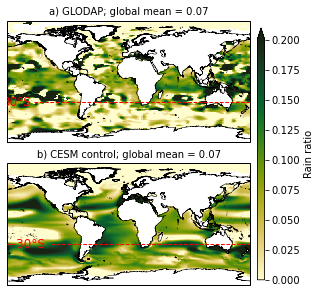

In [89]:
fig = plt.figure(figsize=(5,5))
#plt.suptitle('Rain ratio, Sarmiento et al., 2002 method: GLODAP and CESM', fontsize=14)

#---- GLODAP panel
ax = fig.add_subplot(2,1,1, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('a) GLODAP; global mean = 0.07', fontsize=10,x=0.5, y=1)
pc1=ax.pcolormesh(rain_ratio.lon, rain_ratio.lat,rain_ratio, vmin=0, vmax=0.2, cmap=cmocean.cm.speed,
                 transform=ccrs.PlateCarree())





#---- CESM panel control
lon,lat,field=adjust_pop_grid(lons, lats, cesm_rain_ratio)
ax = fig.add_subplot(2,1,2, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('b) CESM control; global mean = 0.07', fontsize=10,x=0.5, y=1)
pc2=ax.pcolormesh(lon, lat, field, vmin=0, vmax=0.2, cmap=cmocean.cm.speed,
                 transform=ccrs.PlateCarree())




fig.subplots_adjust(right=0.8,hspace=0.1,wspace=0.1)
cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc2, cax=cbar_ax,label='Rain ratio',extend='max')

#fig.savefig('/glade/u/home/kristenk/besome/alk_calc_paper/Figs/rainratio_leftside.png',dpi=600, bbox_inches='tight',format='png');


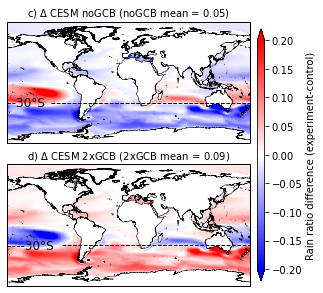

In [92]:
fig = plt.figure(figsize=(5,5))
#plt.suptitle('Rain ratio, Sarmiento et al., 2002 method: GLODAP and CESM', fontsize=14)

#---- CESM panel noGCB
lon,lat,field=adjust_pop_grid(lons, lats, noGCBdiff)
ax = fig.add_subplot(2,1,1, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('c) $\Delta$ CESM noGCB (noGCB mean = 0.05)', fontsize=10,x=0.5, y=1)
pc2=ax.pcolormesh(lon, lat, field, vmin=-0.2, vmax=0.2, cmap='bwr',
                 transform=ccrs.PlateCarree())
######### add lat lines
cs_lat = ax.contour(ds.lon.values,ds.lat.values,lat_grd,
                colors='black',
                levels = [-30.],
                linewidths = 1,
                transform=ccrs.PlateCarree())

fmt = '---30°S'
plt.clabel(cs_lat, colors = 'black', fmt = fmt, fontsize=12)
####################

#---- CESM panel 2xGCB
lon,lat,field=adjust_pop_grid(lons, lats, GCB2xdiff)
ax = fig.add_subplot(2,1,2, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('d) $\Delta$ CESM 2xGCB (2xGCB mean = 0.09)', fontsize=10,x=0.5, y=1)
pc2=ax.pcolormesh(lon, lat, field,vmin=-0.2, vmax=0.2, cmap='bwr',
                 transform=ccrs.PlateCarree())

######### add lat lines
cs_lat = ax.contour(ds.lon.values,ds.lat.values,lat_grd,
                colors='black',
                levels = [-30.],
                linewidths = 1,
                transform=ccrs.PlateCarree())

fmt = '-----30°S'
plt.clabel(cs_lat, colors = 'black', fmt = fmt, fontsize=12)
####################



fig.subplots_adjust(right=0.8,hspace=0.1,wspace=0.1)
cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc2, cax=cbar_ax,label='Rain ratio difference (experiment-control)',extend='both')

fig.savefig('/glade/u/home/kristenk/besome/alk_calc_paper/Figs/rainratio_rightside.png',dpi=600, bbox_inches='tight',format='png');


#### Take a look a rain ratio averaged in biomes

In [41]:
ds_biomes = xr.open_dataset('/glade/work/kristenk/ocean_masks/fay_mckinley_1deg_biomes.nc',decode_times=False,decode_coords=False)

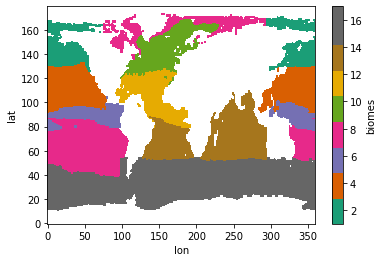

In [42]:
ds_biomes.biomes.plot(cmap=plt.cm.get_cmap('Dark2',17))

In [43]:
cesm_ds_biomes = xr.open_dataset('/glade/work/kristenk/ocean_masks/fay_biomes_POP_rotated.nc',decode_times=False,decode_coords=False)

In [44]:
cesm_ds_biomes = cesm_ds_biomes.rename({'lon': 'nlon','lat': 'nlat'})
cesm_ds_biomes

<xarray.Dataset>
Dimensions:     (nlat: 384, nlon: 320)
Dimensions without coordinates: nlat, nlon
Data variables:
    fay_biomes  (nlat, nlon) float64 ...

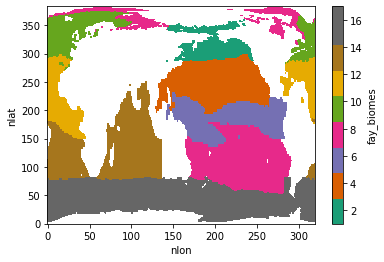

In [45]:
cesm_ds_biomes.fay_biomes.plot(cmap=plt.cm.get_cmap('Dark2',17))

In [46]:
rr_biomes=np.empty([17])

In [47]:
rain_ratio_area = rain_ratio * ds['area'] #GLODAP

In [48]:
landmask=rain_ratio * 0.
landmask=landmask + 1.

area_mask=ds['area'] * landmask

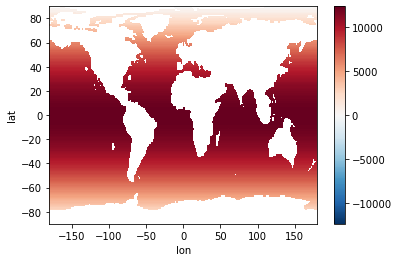

In [49]:
area_mask.plot()

In [50]:
for i in range(0,len(rr_biomes)):
    rr_biomes[i] = rain_ratio_area.where(ds_biomes.biomes==i+1).sum() / area_mask.where(ds_biomes.biomes==i+1).sum()

In [51]:
rr_biomes

array([-0.21186812, -0.00111527,  0.08725639,  0.09463821,  0.10795897,
        0.09537836,  0.23574665, -0.38693269, -0.01123754,  0.07462571,
        0.00584923,  0.08336503,  0.05978879,  0.08951125, -0.01314261,
       -0.02242133,  0.01974198])

In [52]:
glodap_biomes_rr_gridded=np.full((180, 360), np.nan)

In [53]:
for i in range(0,len(rr_biomes)):
    
    rr=rr_biomes[i]
    rr_mask=np.full((180, 360), rr)

    #make ds_biomes.biomes a numpy array with only one masked biome
    masked_biome = ds_biomes.biomes.where(ds_biomes.biomes==i+1)
    masked_biome = np.asarray(masked_biome)
    glodap_biomes_rr_gridded[~np.isnan(masked_biome)] = rr_mask[~np.isnan(masked_biome)]

In [54]:
glodap_biomes_rr_gridded=xr.DataArray(glodap_biomes_rr_gridded)
glodap_biomes_rr_gridded=glodap_biomes_rr_gridded.rename({'dim_0':'lat'})
glodap_biomes_rr_gridded=glodap_biomes_rr_gridded.rename({'dim_1':'lon'})

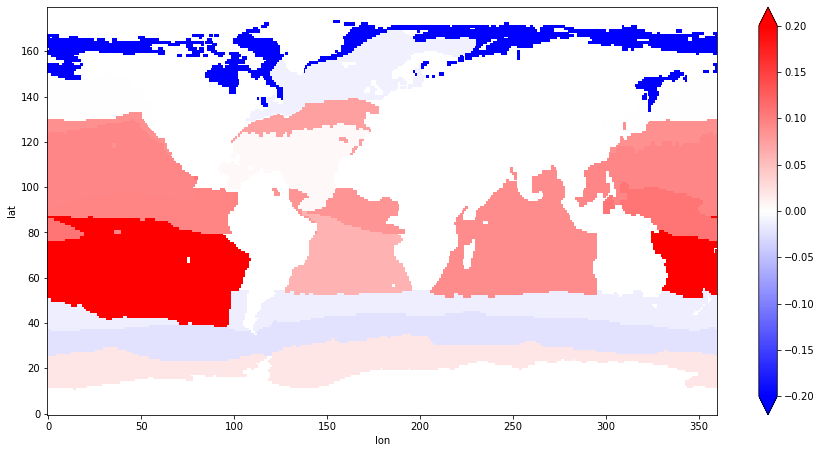

In [55]:
glodap_biomes_rr_gridded.plot(figsize=(15,7.5),vmin=-0.2,vmax=0.2,cmap='bwr')

### and now in CESM

### CONTROL

In [56]:
%%time
cesm_rr_biomes=np.empty([17])

for b in range(0,len(cesm_rr_biomes)):
    tmp = cesm_rain_ratio.where(cesm_ds_biomes.fay_biomes==b+1)
    #dims:nlat,nlon
    tmp = esmlab.weighted_mean(tmp, weights=cesm_ds.TAREA, dim=['nlat', 'nlon']).compute()
    #dims: none
    cesm_rr_biomes[b]=tmp.values

CPU times: user 78.9 ms, sys: 1.71 ms, total: 80.6 ms
Wall time: 79.7 ms


In [57]:
cesm_rr_biomes

array([-0.1538903 ,  0.03760154,  0.09310873,  0.10006789,  0.0512443 ,
        0.07101698,  0.05170721, -0.36235575, -0.01834949,  0.08847583,
        0.10775955,  0.11252484,  0.12684394,  0.07251592,  0.11442477,
        0.06906736,  0.05954371])

In [58]:
cesm_rr_biomes_gridded=np.full((384, 320), np.nan)

In [59]:
for i in range(0,len(cesm_rr_biomes)):
    
    rr=cesm_rr_biomes[i]
    rr_mask=np.full((384, 320), rr)

    #make ds_biomes.biomes a numpy array with only one masked biome
    masked_biome = cesm_ds_biomes.fay_biomes.where(cesm_ds_biomes.fay_biomes==i+1)
    masked_biome = np.asarray(masked_biome)
    cesm_rr_biomes_gridded[~np.isnan(masked_biome)] = rr_mask[~np.isnan(masked_biome)]

In [60]:
cesm_rr_biomes_gridded=xr.DataArray(cesm_rr_biomes_gridded)
cesm_rr_biomes_gridded=cesm_rr_biomes_gridded.rename({'dim_0':'nlat'})
cesm_rr_biomes_gridded=cesm_rr_biomes_gridded.rename({'dim_1':'nlon'})

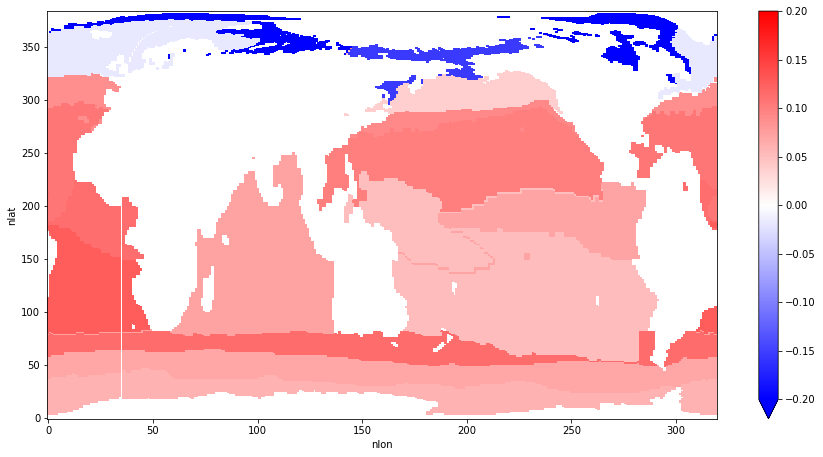

In [61]:
cesm_rr_biomes_gridded.plot(figsize=(15,7.5),vmin=-0.2,vmax=0.2,cmap='bwr')

### noGCB

In [62]:
%%time
cesm_rr_biomes_noGCB=np.empty([17])

for b in range(0,len(cesm_rr_biomes_noGCB)):
    tmp = cesm_rain_ratio_noGCB.where(cesm_ds_biomes.fay_biomes==b+1)
    #dims:nlat,nlon
    tmp = esmlab.weighted_mean(tmp, weights=cesm_ds.TAREA, dim=['nlat', 'nlon']).compute()
    #dims: none
    cesm_rr_biomes_noGCB[b]=tmp.values

CPU times: user 78.3 ms, sys: 1.89 ms, total: 80.2 ms
Wall time: 78.9 ms


In [63]:
cesm_rr_biomes_noGCB

array([-0.16650355,  0.02757664,  0.07584759,  0.06566442,  0.05363239,
        0.06781123,  0.08797002, -0.36026206, -0.0207254 ,  0.07741416,
        0.09297238,  0.1055746 ,  0.11392365,  0.08733202,  0.01926269,
        0.00359345, -0.02004569])

In [64]:
cesm_rr_biomes_noGCB_gridded=np.full((384, 320), np.nan)

In [65]:
for i in range(0,len(cesm_rr_biomes_noGCB)):
    
    rr=cesm_rr_biomes_noGCB[i]
    rr_mask=np.full((384, 320), rr)

    #make ds_biomes.biomes a numpy array with only one masked biome
    masked_biome = cesm_ds_biomes.fay_biomes.where(cesm_ds_biomes.fay_biomes==i+1)
    masked_biome = np.asarray(masked_biome)
    cesm_rr_biomes_noGCB_gridded[~np.isnan(masked_biome)] = rr_mask[~np.isnan(masked_biome)]

In [66]:
cesm_rr_biomes_noGCB_gridded=xr.DataArray(cesm_rr_biomes_noGCB_gridded)
cesm_rr_biomes_noGCB_gridded=cesm_rr_biomes_noGCB_gridded.rename({'dim_0':'nlat'})
cesm_rr_biomes_noGCB_gridded=cesm_rr_biomes_noGCB_gridded.rename({'dim_1':'nlon'})

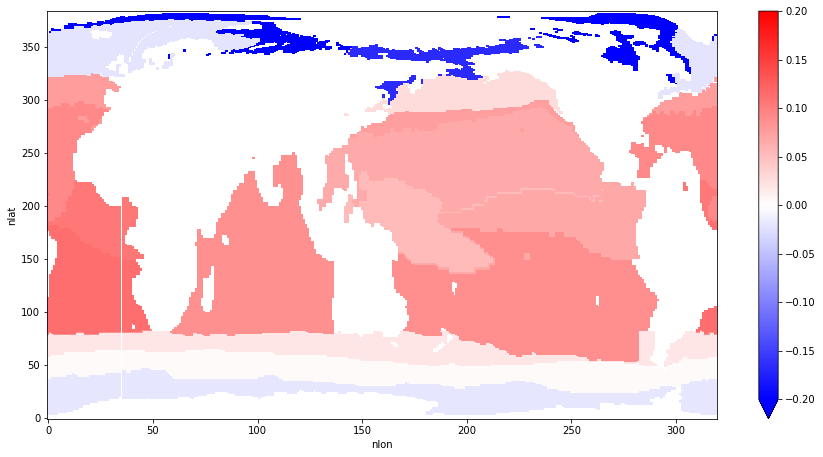

In [67]:
cesm_rr_biomes_noGCB_gridded.plot(figsize=(15,7.5),vmin=-0.2,vmax=0.2,cmap='bwr')

### 2xGCB

In [68]:
%%time
cesm_rr_biomes_2xGCB=np.empty([17])

for b in range(0,len(cesm_rr_biomes_2xGCB)):
    tmp = cesm_rain_ratio_2xGCB.where(cesm_ds_biomes.fay_biomes==b+1)
    #dims:nlat,nlon
    tmp = esmlab.weighted_mean(tmp, weights=cesm_ds.TAREA, dim=['nlat', 'nlon']).compute()
    #dims: none
    cesm_rr_biomes_2xGCB[b]=tmp.values

CPU times: user 79.3 ms, sys: 947 µs, total: 80.3 ms
Wall time: 79.1 ms


In [69]:
cesm_rr_biomes_2xGCB

array([-0.14127822,  0.04762586,  0.11037053,  0.13447135,  0.04885634,
        0.07422291,  0.01544403, -0.36444814, -0.01597278,  0.09953769,
        0.12254687,  0.11947498,  0.13976432,  0.05770066,  0.20958753,
        0.13454106,  0.1391338 ])

In [70]:
cesm_rr_biomes_2xGCB_gridded=np.full((384, 320), np.nan)

In [71]:
for i in range(0,len(cesm_rr_biomes_2xGCB)):
    
    rr=cesm_rr_biomes_2xGCB[i]
    rr_mask=np.full((384, 320), rr)

    #make ds_biomes.biomes a numpy array with only one masked biome
    masked_biome = cesm_ds_biomes.fay_biomes.where(cesm_ds_biomes.fay_biomes==i+1)
    masked_biome = np.asarray(masked_biome)
    cesm_rr_biomes_2xGCB_gridded[~np.isnan(masked_biome)] = rr_mask[~np.isnan(masked_biome)]

In [72]:
cesm_rr_biomes_2xGCB_gridded=xr.DataArray(cesm_rr_biomes_2xGCB_gridded)
cesm_rr_biomes_2xGCB_gridded=cesm_rr_biomes_2xGCB_gridded.rename({'dim_0':'nlat'})
cesm_rr_biomes_2xGCB_gridded=cesm_rr_biomes_2xGCB_gridded.rename({'dim_1':'nlon'})

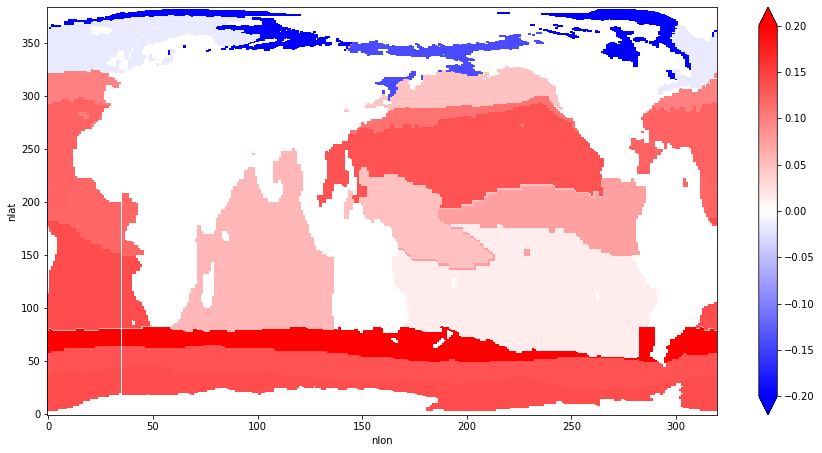

In [73]:
cesm_rr_biomes_2xGCB_gridded.plot(figsize=(15,7.5),vmin=-0.2,vmax=0.2,cmap='bwr')

### put all the rain ratio maps together

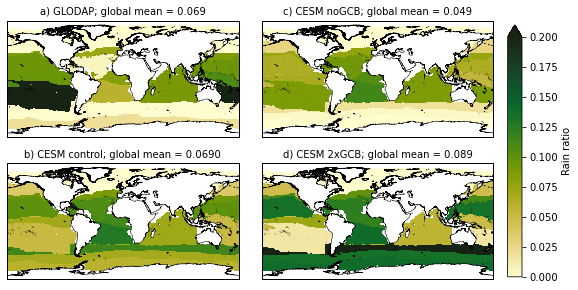

In [74]:
fig = plt.figure(figsize=(10,5))
#plt.suptitle('Rain ratio, Sarmiento et al., 2002 method: GLODAP and CESM', fontsize=14)

#---- GLODAP panel
ax = fig.add_subplot(2,2,1, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('a) GLODAP; global mean = 0.069', fontsize=10,x=0.5, y=1)
pc1=ax.pcolormesh(rain_ratio.lon, rain_ratio.lat,glodap_biomes_rr_gridded, vmin=0, vmax=0.2, cmap=cmocean.cm.speed,
                 transform=ccrs.PlateCarree())


#---- CESM panel control
lon,lat,field=adjust_pop_grid(lons, lats, cesm_rr_biomes_gridded)
ax = fig.add_subplot(2,2,3, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('b) CESM control; global mean = 0.0690', fontsize=10,x=0.5, y=1)
pc2=ax.pcolormesh(lon, lat, field, vmin=0, vmax=0.2, cmap=cmocean.cm.speed,
                 transform=ccrs.PlateCarree())


#---- CESM panel noGCB
lon,lat,field=adjust_pop_grid(lons, lats, cesm_rr_biomes_noGCB_gridded)
ax = fig.add_subplot(2,2,2, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('c) CESM noGCB; global mean = 0.049', fontsize=10,x=0.5, y=1)
pc2=ax.pcolormesh(lon, lat, field, vmin=0, vmax=0.2, cmap=cmocean.cm.speed,
                 transform=ccrs.PlateCarree())



#---- CESM panel 2xGCB
lon,lat,field=adjust_pop_grid(lons, lats, cesm_rr_biomes_2xGCB_gridded)
ax = fig.add_subplot(2,2,4, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('d) CESM 2xGCB; global mean = 0.089', fontsize=10,x=0.5, y=1)
pc2=ax.pcolormesh(lon, lat, field,vmin=0, vmax=0.2, cmap=cmocean.cm.speed,
                 transform=ccrs.PlateCarree())



fig.subplots_adjust(right=0.8,hspace=0.1,wspace=0.1)
cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc2, cax=cbar_ax,label='Rain ratio',extend='max')

#fig.savefig('/glade/u/home/kristenk/besome/alk_calc_paper/Figs/rainratio.png',dpi=600, bbox_inches='tight',format='png');


In [75]:
### calculate experiment differences from control
noGCBdiff=cesm_rr_biomes_noGCB_gridded - cesm_rr_biomes_gridded
GCB2xdiff=cesm_rr_biomes_2xGCB_gridded - cesm_rr_biomes_gridded

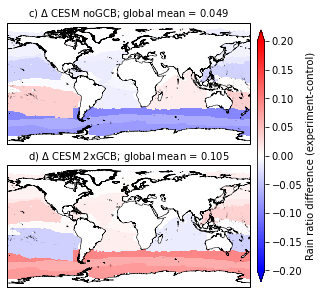

In [76]:
fig = plt.figure(figsize=(5,5))
#plt.suptitle('Rain ratio, Sarmiento et al., 2002 method: GLODAP and CESM', fontsize=14)

#---- CESM panel noGCB
lon,lat,field=adjust_pop_grid(lons, lats, noGCBdiff)
ax = fig.add_subplot(2,1,1, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('c) $\Delta$ CESM noGCB; global mean = 0.049', fontsize=10,x=0.5, y=1)
pc2=ax.pcolormesh(lon, lat, field, vmin=-0.2, vmax=0.2, cmap='bwr',
                 transform=ccrs.PlateCarree())


#---- CESM panel 2xGCB
lon,lat,field=adjust_pop_grid(lons, lats, GCB2xdiff)
ax = fig.add_subplot(2,1,2, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('d) $\Delta$ CESM 2xGCB; global mean = 0.105', fontsize=10,x=0.5, y=1)
pc2=ax.pcolormesh(lon, lat, field,vmin=-0.2, vmax=0.2, cmap='bwr',
                 transform=ccrs.PlateCarree())

fig.subplots_adjust(right=0.8,hspace=0.1,wspace=0.1)
cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc2, cax=cbar_ax,label='Rain ratio difference (experiment-control)',extend='both')

#fig.savefig('/glade/u/home/kristenk/besome/alk_calc_paper/Figs/rainratio_rightside.png',dpi=600, bbox_inches='tight',format='png');


### Calculate rain rain ratio the more direct way in CESM

In [77]:
cesm_rain_ratio2 = cesm_ds.CaCO3_FLUX_IN.isel(z_t=10) / cesm_ds.POC_FLUX_IN.isel(z_t=10)

In [78]:
global_mean_rr = esmlab.weighted_mean(cesm_rain_ratio2, weights=cesm_ds.TAREA, dim=['nlat', 'nlon']).compute()
global_mean_rr

<xarray.DataArray ()>
array(0.14897067)
Coordinates:
    z_t      float32 10500.0
Attributes:
    long_name:     CaCO3 Flux into Cell
    units:         mmol/m^3 cm/s
    grid_loc:      3111
    cell_methods:  time: mean
    coordinates:   TLONG TLAT

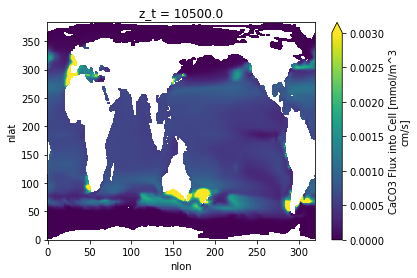

In [79]:
cesm_ds.CaCO3_FLUX_IN.isel(z_t=10).plot(vmin=0,vmax=0.003)

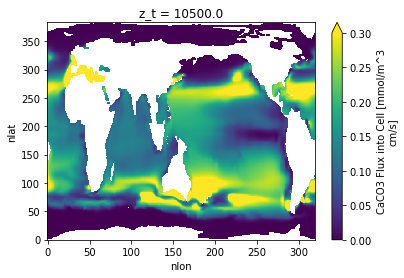

In [80]:
cesm_rain_ratio2.plot(vmin=0, vmax=0.3)

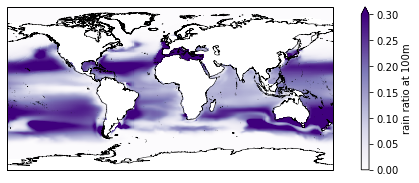

In [81]:
fig = plt.figure(figsize=(10,3))
#plt.suptitle('Rain ratio, CaCO3 flux/POC flux at 100m', fontsize=14)

ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
pc2=ax.pcolormesh(lons, lats, cesm_rain_ratio2, vmin=0, vmax=0.3, cmap='Purples',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='rain ratio at 100m')

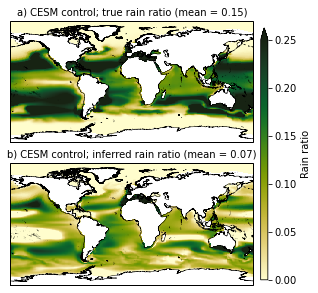

In [82]:
fig = plt.figure(figsize=(5,5))
#plt.suptitle('Rain ratio, Sarmiento et al., 2002 method: GLODAP and CESM', fontsize=14)

#---- CESM true rain ratio
lon,lat,field=adjust_pop_grid(lons, lats, cesm_rain_ratio2)
ax = fig.add_subplot(2,1,1, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('a) CESM control; true rain ratio (mean = 0.15)', fontsize=10,x=0.5, y=1)
pc1=ax.pcolormesh(lon, lat, field, vmin=0, vmax=0.25, cmap=cmocean.cm.speed,
                 transform=ccrs.PlateCarree())


#---- CESM panel control
lon,lat,field=adjust_pop_grid(lons, lats, cesm_rain_ratio)
ax = fig.add_subplot(2,1,2, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('b) CESM control; inferred rain ratio (mean = 0.07)', fontsize=10,x=0.5, y=1)
pc2=ax.pcolormesh(lon, lat, field, vmin=0, vmax=0.25, cmap=cmocean.cm.speed,
                 transform=ccrs.PlateCarree())




fig.subplots_adjust(right=0.8,hspace=0.1,wspace=0.1)
cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc2, cax=cbar_ax,label='Rain ratio',extend='max')

fig.savefig('/glade/u/home/kristenk/besome/alk_calc_paper/Figs/rainratio_leftside.png',dpi=600, bbox_inches='tight',format='png');
